In [3]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imprint as ip
import imprint.bound.normal as normal
from imprint.models.ztest import ZTest1D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def tie(theta, thresh):
    return scipy.stats.norm.sf(thresh-theta)

In [87]:
theta_min = -1
theta_max = 0
alpha = 0.025
n_sims = 1000

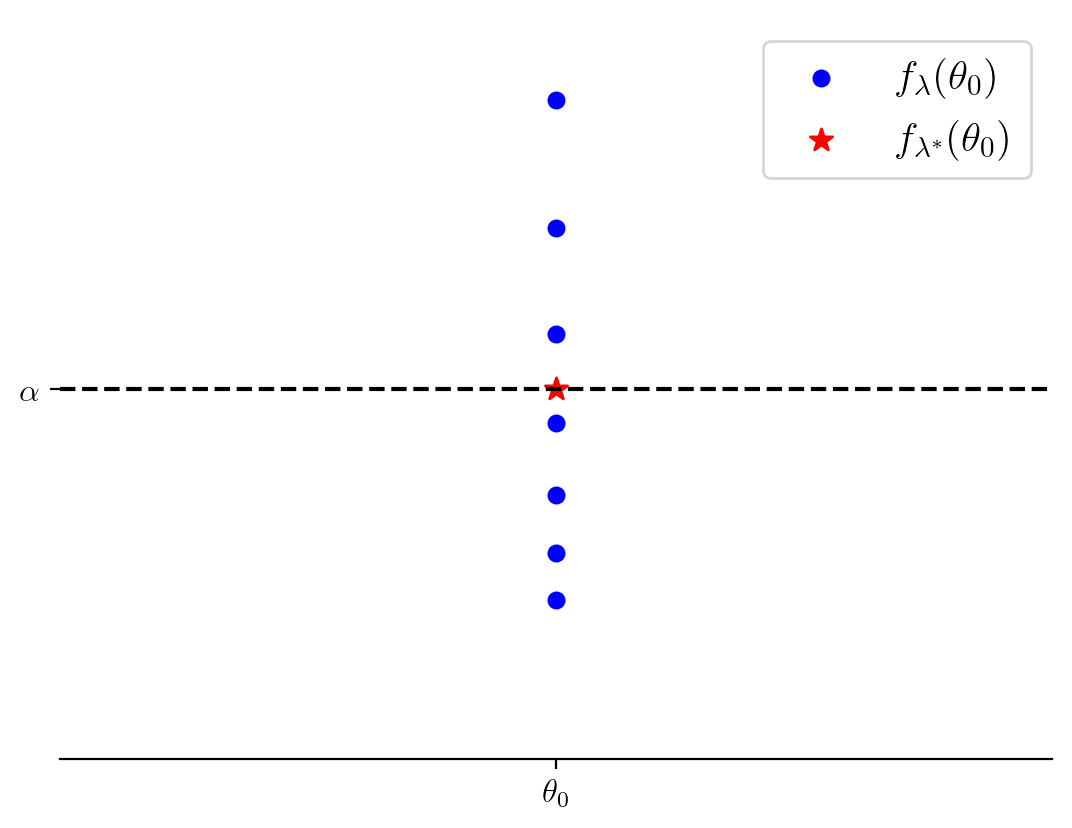

In [88]:
theta0 = -0.5
ts = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8])
ties = tie(theta0, ts)

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
ax.scatter(np.full(len(ties), theta0), ties, s=30, color='b', label='$f_{\lambda}(\\theta_0)$')
ax.scatter(theta0, alpha, s=70, color='r', marker='*', label='$f_{\lambda^*}(\\theta_0)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.set_xticks([theta0], labels=['$\\theta_0$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta0+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
plt.legend()
plt.savefig('figures/calibration_point_null.pdf', bbox_inches='tight')
plt.show()

In [148]:
def calib_tie(theta0, n_sims, alpha):
    k = int((n_sims + 1) * alpha)
    return k / (n_sims + 1)

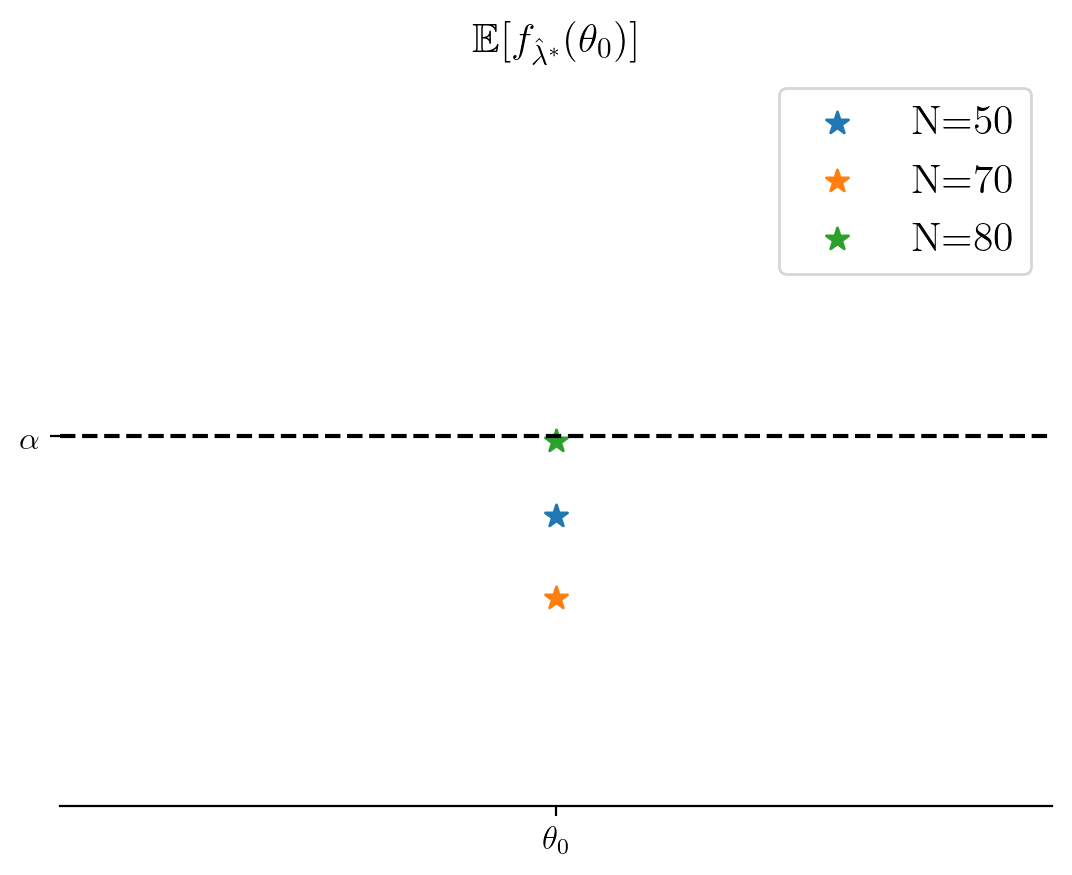

In [159]:
n_sims_list = np.array([50, 70, 80])
calib_ties = np.array([calib_tie(theta0, n, alpha) for n in n_sims_list])

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
for n_sim, tie in zip(n_sims_list, calib_ties):
    ax.scatter(theta0, tie, 
        s=70, marker='*',
        label=f"N={n_sim}",
    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.set_xticks([theta0], labels=['$\\theta_0$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta0+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
ax.set_title('$\mathbb{E}[f_{\hat{{\lambda}}^*}(\\theta_0)]$')
plt.legend()
plt.savefig('figures/calibration_point_null_solution.pdf', bbox_inches='tight')
plt.show()

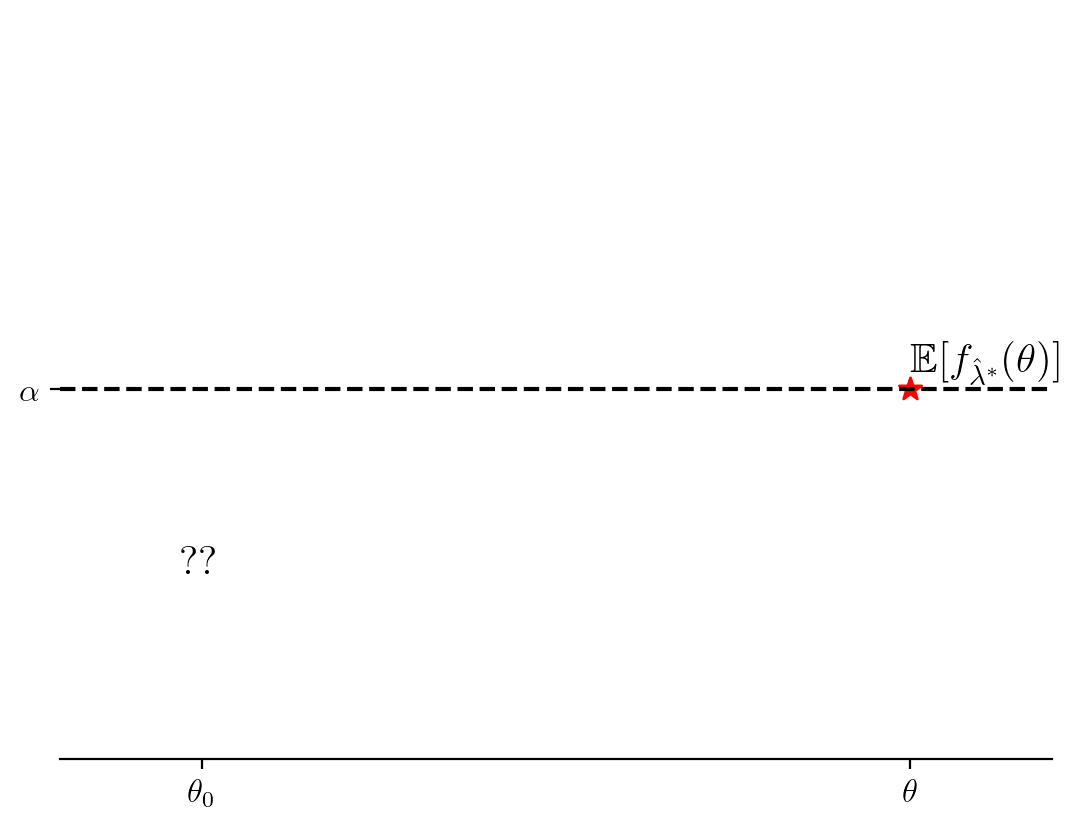

In [115]:
theta = theta_max

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
ax.scatter(theta, alpha, s=70, marker='*', color='r')
ax.annotate("??", (theta0-1.5e-2, alpha / 2))
ax.annotate("$\mathbb{E}[f_{\hat{{\lambda}}^*}(\\theta)]$", (theta, alpha * 1.05))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
plt.savefig('figures/calibration_tile.pdf', bbox_inches='tight')
plt.show()

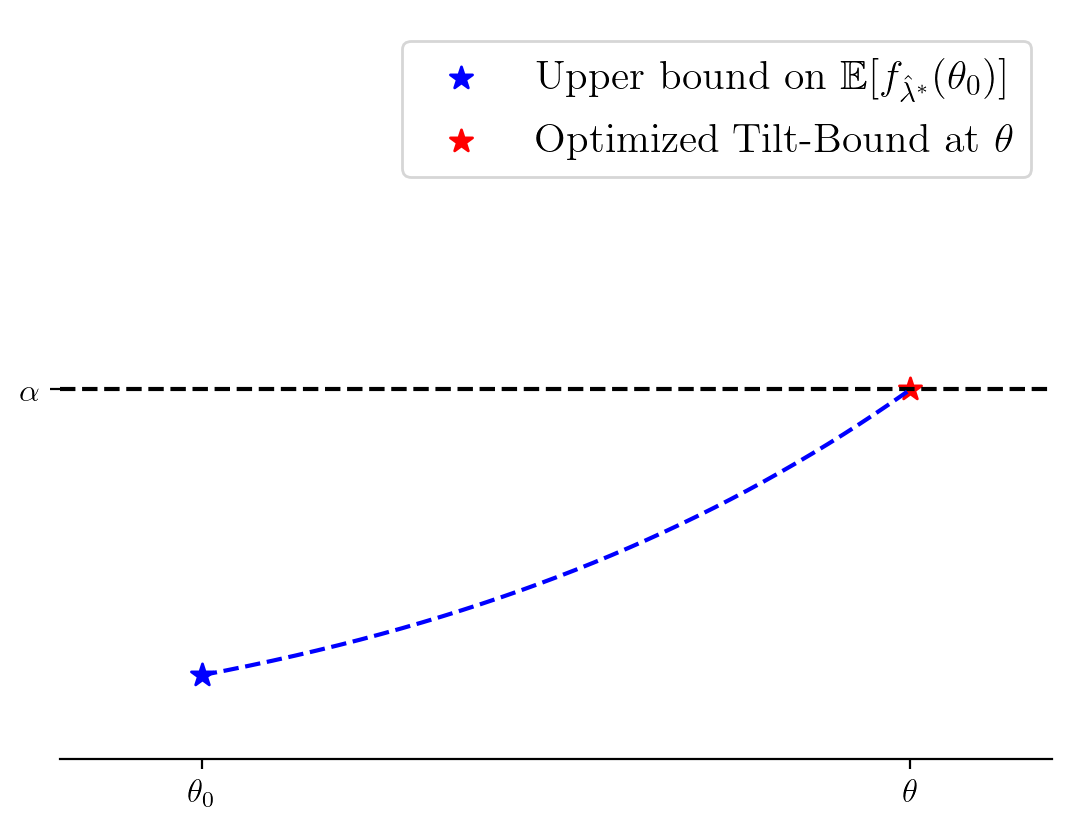

In [116]:
bwd_solver = normal.BackwardQCPSolver(1)
v = theta-theta0
q = bwd_solver.solve(v, alpha)
bound = normal.tilt_bound_bwd_tile(q, 1, v, alpha)

vs = jnp.linspace(0, theta-theta0, 1000)
fwd_solver = normal.ForwardQCPSolver(1)
fwd_qs = jax.vmap(fwd_solver.solve, in_axes=(0, None))(vs, bound)
fwd_bounds = jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None))(fwd_qs, 1, vs, bound)

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.axhline(alpha, linestyle='--', color='k')
ax.scatter(theta0, bound, s=70, marker='*', color='b', 
    label='Upper bound on $\mathbb{E}[f_{\hat{{\lambda}}^*}(\\theta_0)$]',
)
ax.scatter(theta, alpha, s=70, marker='*', color='r', 
    label='Optimized Tilt-Bound at $\\theta$',
)
ax.plot(theta0 + vs, fwd_bounds, linestyle='--', color='b')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.axes.set_yticks([alpha], labels=['$\\alpha$'])
ax.set_xlim(left=theta0-0.1, right=theta+0.1)
ax.set_ylim(bottom=0, top=2 * alpha)
plt.legend()
plt.savefig('figures/calibration_tile_solution.pdf', bbox_inches='tight')
plt.show()

In [123]:
def beta_integrated_TIE(npt, nsims, alpha=0.025):
    radius = 0.5 / npt
    qback = normal.BackwardQCPSolver(scale=1)
    qback = qback.solve(radius, alpha)
    optboundback = normal.tilt_bound_bwd(qback, 1, radius, alpha)
    orderstat = int(optboundback * (nsims + 1))
    betaparams = (orderstat, nsims + 1 - orderstat)
    return scipy.stats.beta.expect(
        lambda x: scipy.stats.norm.cdf(-radius + scipy.stats.norm.ppf(x)),
        betaparams,
    )

def vectorize_over_nsim(npt, nsims, alpha):
    return np.array([beta_integrated_TIE(npt, nsim, alpha) for nsim in nsims])


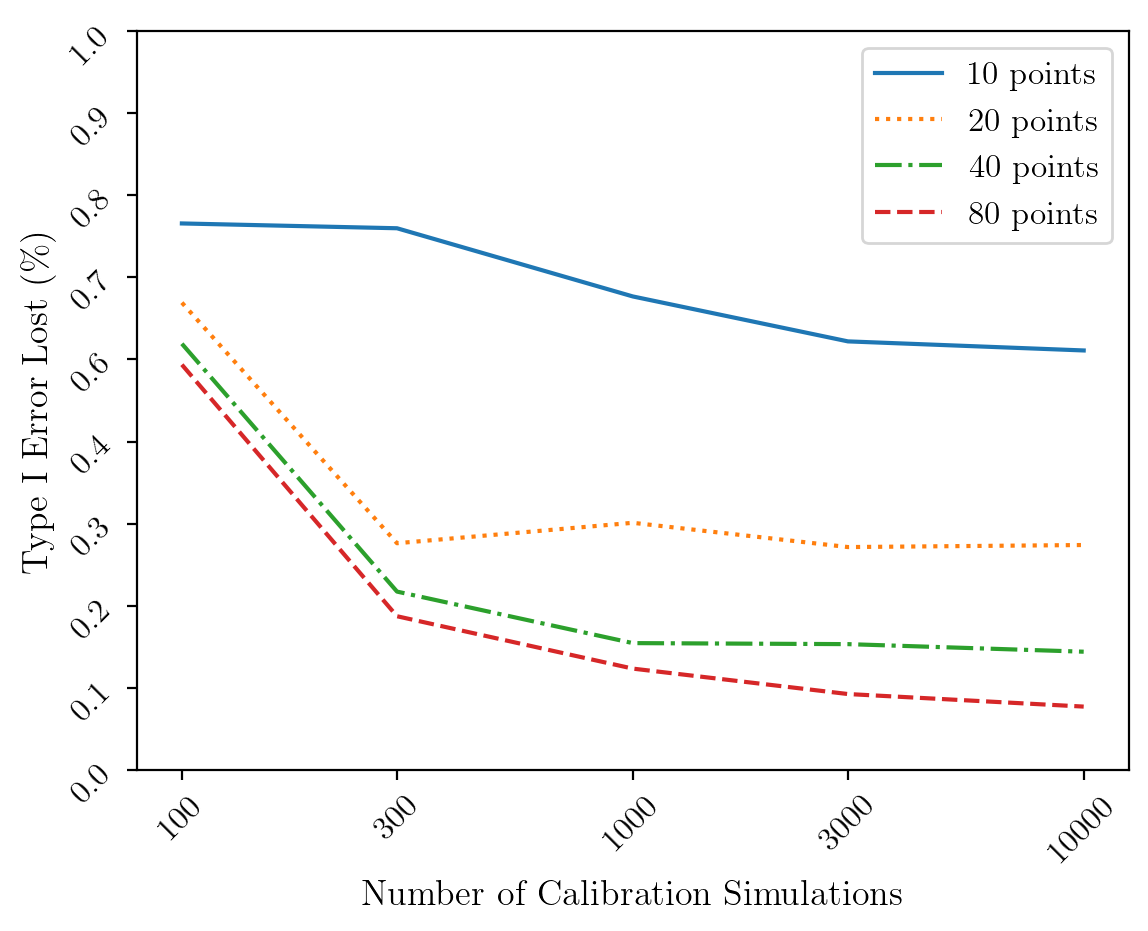

In [127]:
styles = ["-", ":", "-.", "--"]
npts = np.array([10, 20, 40, 80])
nsims = np.array([100, 300, 1000, 3000, 10000])

for i in range(len(npts)):
    temp = vectorize_over_nsim(npts[i], nsims, alpha)
    plt.plot(np.log(nsims), alpha - temp, linestyle=styles[i], label=f"{npts[i]:.0f} points")

plt.legend(fontsize=12)
plt.ylabel("Type I Error Lost (\%)")
yticks = np.linspace(0, 0.01, 10)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.01f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xticks(np.log(nsims), rotation=45)
plt.gca().set_xticklabels(nsims)
plt.xlabel("Number of Calibration Simulations")
plt.savefig("figures/z-test-cost.pdf", bbox_inches="tight")
plt.show()